## IMAGING BASED SCREEN

by Anastasia Abashidze


Blavatnik Center for Drug Discovery

## Introduction
  
#### HCS

<div align="justify"> High-content screening (HCS), also known as high-content analysis (HCA) or cellomics, is a method that is used to identify substances altering the phenotype of a cell in the desired manner. Hence HCS is a phenotypic screen conducted in cell cultures involving the analysis of whole cells or components of cells with simultaneous readout of several parameters. Phenotypic changes may include increases or decreases in the production of cellular products such as proteins and/or changes in the morphology (visual appearance) of the cell. HCA typically involves automated microscopy and image analysis, and in some cases can be high in content but low in throughput. </div>  

<div align="justify">In HCS, cells are first incubated with the compounds and after some time, structures and molecular components of the cells are analyzed. The most common analysis involves labeling proteins with fluorescent tags and then quantification of changes using automated image analysis software. Through the use of fluorescent tags with different absorption and emission maxima, it is possible to measure several different cell components in parallel (e.g., cytoplasm vs. nucleus vs. other organelles). The blue channel routinely used for nuclei staining, and green, red, and far-red channels are used to stain cell components. Therefore a large number of features can be collected per cell. </div>

<img style ="float: left; margin-right:700px"  width ="550" src = "hts_images/seg_example.PNG" >
Exapmle of image segmentation performed by commercial software. Cell borders are outlined in green, organelles are outlined in red.

#### Assay Data

<div align="justify"> In this tutorial we analyze screen results obtained from image analysis software that accompanies automated confocal image reader InCell Analyzer 2200. In imaging based data, each row of the dataset can represent well (by well analysis), field (by field analysis), or cell (by cell analysis). In our example we are starting with field data, there are 10 fields for each well. 
    </div>

<div align="justify"> We search for compounds which can activate some transcription factor (TF) of interest. The red fluorescence reporter gene is attached to the promoter of selected TF-responsive gene (TF target gene) so that red fluorescence intensities of expressed reporter protein reflect levels of activation of the TF. The red fluorescence measurements are stored in 'RFP' column. Since the imaging is performed with live cell cultures, we use Calcein AM staining to measure total cell area and viability. In live cells the nonfluorescent calcein AM is converted to a green-fluorescent calcein after acetoxymethyl ester hydrolysis by intracellular esterases.The green Calcein fluorescence measurements are stored in 'Cell_Intensity' column. </div>

<div align="justify">Following assay development guidelines, we consider compound as hit if it's normalized activity as far as 2 standard deviations from the mean activity calculated for rest of the conpounds in the plate. (Two standard deviations disctance is defined as threshold variable at the beginning of the script).</div>

#### Systematic Errors

<div align="justify">  Even the most carefully performed screens contain two types of measurement error – random and systematic errors. Inherent random variability of assay measurements cannot be eliminated or controlled. In contrast, systematic errors can be estimated and removed. Well-known systematic errors include row, column, or edge effects and are often characterized by gradients toward the center of the plate, affecting activity measurements of both controls and features of interest. </div>

<div align="justify"> Many technical, procedural, or environmental factors can cause systematic measurement errors. Such systematic errors have the potential to critically affect the hit selection process. However, systematic error correction methods themselves can introduce systematic bias when applied to error-free HTS data (Makarenkov et al.) Thus, the presence or absence of systematic bias in raw HTS data must be first confirmed by the appropriate statistical tests (here we use Welch’s t-test). 
</div>

## References

* High Content Screening (https://en.wikipedia.org/wiki/High-content_screening)
* Iurie Caraus, Abdulaziz A. Alsuwailem, Robert Nadon, Vladimir Makarenkov, Detecting and overcoming systematic bias in high-throughput screening technologies: a comprehensive review of practical issues and methodological solutions. Briefings in Bioinformatics, 2015. https://doi.org/10.1093/bib/bbv004
* Makarenkov, V., Zentilli, P., Kevorkov, D. An Efficient Method for the Detection and Elimination of Systematic Error in High-Throughput Screening. Bioinformatics 2007, 23, 1648–1657.
* Dragiev, P., Nadon, R. & Makarenkov, V. Systematic error detection in experimental high-throughput screening. BMC Bioinformatics 12, 25 (2011). https://doi.org/10.1186/1471-2105-12-25
* Sittampalam GS, Grossman A, Brimacombe K, et al., editors. Assay Guidance Manual.

## The Workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)        
[Add Layout](#layout)  
[Normalize by Viability](#via_norm)  
[Generate by Well Data](#results)   
[Systematic Error Correction](#er_cor)  
 - [Welch t-test](#ttest) 
 - [Median Polish Algorithm](#mp) 
 
[Running QC](#qc)    
[Conclusions](#save)
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [31]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
#%load_ext autoreload
#%autoreload 2
#hide
from simplydrug.core import *

#### Create folder to save the output

In [32]:
path = ('imaging_screen_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

#### Defining parameters

In [33]:
# path to data
data_path = 'hts_data//cell_screen_fields.xlsx'

# path to layout
layout_path = 'hts_data//cell_screen_layout.xlsx'

#path to chemical library
chem_path = 'hts_data//compounds//example_chemicals.csv'

# which compounds to import to the layout
chem_plate = 'ex_plate1'

# how to name the output files
name = 'image_screen_run1'

# define threshold - two standard deviations from the mean plate activity 
threshold = 2

palette = {'Sample':'Navy','Negative':'Darkred','Positive':'Darkgreen', 'Hit': 'Orange', 'Invalid_sample':'Darkgray'}
hue_order = ['Sample', 'Negative', 'Positive', 'Hit', 'Invalid_sample']

### Load Data
<a id="load_data"></a>

In [34]:
data = pd.DataFrame(pd.ExcelFile(data_path).parse(0))
print(data.shape)
display(data.head())

(3680, 10)


,Well,Nuc Area,Cell Area,Cells_Background Intensity,Cells_Intensity (N+C)_raw,Ref_Background Intensity,Ref_Intensity (N+C),Cell_Count,Cell_Intensity,RFP
0,A - 3(fld 01),124.342,245.026,11868.942,19985.581,669.419,815.286,721,8116.639,145.867
1,A - 3(fld 02),119.247,241.826,10726.076,17219.634,753.825,894.446,971,6493.558,140.621
2,A - 3(fld 03),118.427,239.436,12422.367,18783.938,783.554,930.932,1074,6361.571,147.378
3,A - 3(fld 04),123.570,249.733,11758.683,19193.633,724.785,879.865,922,7434.950,155.080
4,A - 3(fld 05),110.461,208.695,12613.547,16706.001,872.133,975.856,1387,4092.454,103.723


#### Split 'Well column to 'Well' and 'Field'

In [35]:
split = data['Well'].str.split('[(]', n = 1, expand = True) # making seperate column for well and field
data['Field']= split[1].str.replace(')', '', regex=True)
data['Well'] = data['Well'].replace(to_replace=[' - ', '(\(fld .*)', ' '], value ='', regex=True)
display(data.head())

,Well,Nuc Area,Cell Area,Cells_Background Intensity,Cells_Intensity (N+C)_raw,Ref_Background Intensity,Ref_Intensity (N+C),Cell_Count,Cell_Intensity,RFP,Field
0,A3,124.342,245.026,11868.942,19985.581,669.419,815.286,721,8116.639,145.867,fld 01
1,A3,119.247,241.826,10726.076,17219.634,753.825,894.446,971,6493.558,140.621,fld 02
2,A3,118.427,239.436,12422.367,18783.938,783.554,930.932,1074,6361.571,147.378,fld 03
3,A3,123.570,249.733,11758.683,19193.633,724.785,879.865,922,7434.950,155.080,fld 04
4,A3,110.461,208.695,12613.547,16706.001,872.133,975.856,1387,4092.454,103.723,fld 05


### Add Layout
<a id="layout"></a>

In [36]:
data = add_layout(df = data, layout_path = layout_path , chem_path = chem_path, chem_plate = chem_plate)
display(data.head())

Added  Well
Added  Status
Added compounds:  ex_plate1 



,Well,Nuc Area,Cell Area,Cells_Background Intensity,Cells_Intensity (N+C)_raw,Ref_Background Intensity,Ref_Intensity (N+C),Cell_Count,Cell_Intensity,RFP,Field,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName
0,A3,124.342,245.026,11868.942,19985.581,669.419,815.286,721,8116.639,145.867,fld 01,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN
1,A3,119.247,241.826,10726.076,17219.634,753.825,894.446,971,6493.558,140.621,fld 02,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN
2,A3,118.427,239.436,12422.367,18783.938,783.554,930.932,1074,6361.571,147.378,fld 03,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN
3,A3,123.570,249.733,11758.683,19193.633,724.785,879.865,922,7434.950,155.080,fld 04,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN
4,A3,110.461,208.695,12613.547,16706.001,872.133,975.856,1387,4092.454,103.723,fld 05,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN


#### Explore data

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3680 entries, 0 to 3679
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Well                        3680 non-null   object 
 1   Nuc Area                    3680 non-null   float64
 2   Cell Area                   3680 non-null   float64
 3   Cells_Background Intensity  3680 non-null   float64
 4   Cells_Intensity (N+C)_raw   3680 non-null   float64
 5   Ref_Background Intensity    3680 non-null   float64
 6   Ref_Intensity (N+C)         3680 non-null   float64
 7   Cell_Count                  3680 non-null   int64  
 8   Cell_Intensity              3680 non-null   float64
 9   RFP                         3680 non-null   float64
 10  Field                       3680 non-null   object 
 11  Status                      3680 non-null   object 
 12  Plate                       3190 non-null   object 
 13  Compound_id                 3190 

<div align="justify"> Our data contain 368 wells and 10 fields for each well. Nuclear areas are defined by blue nuclei staining. 'Cell Area', 'Cells_Background Intensity', and 'Cells_Intensity (N+C)' are defined by green channel (Calcein staining). 'Cell Intensity' column represents Calcein cell intensity after subtracting Background fluorescence. Similarly, 'RFP' column represents normalized red fluorescence. 'Cell Count' column represent cell counts per field.  </div>

####  Normalize features 

In [38]:
features  = ['Cell_Count', 'Cell_Intensity', 'RFP']
for f in features:
    data = normalize_z(data.copy(), f)

#### Heatmap features

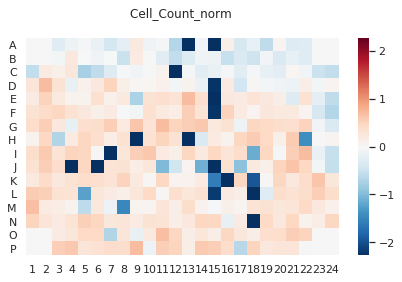

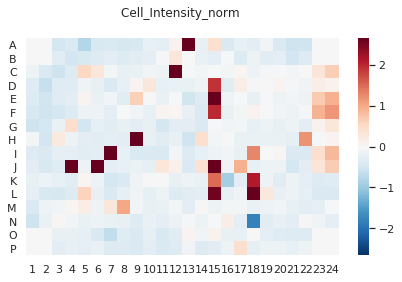

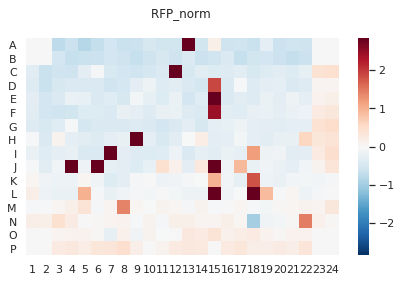

In [39]:
features  = ['Cell_Count_norm', 'Cell_Intensity_norm', 'RFP_norm']
hts_heatmap(df = data, layout_path = layout_path, features = features, save_as = f + 'heatmap.png', path = path)

### Normalize Activity by Viability
<a id="via_norm"></a>

<div align="justify"> From heatmaps, we can notice that most of the wells with strong red signals have low cell counts. In addition, these wells usually have high Calcein intensities, which can be explained by apoptotic cell swelling. Hence, these wells are probably contained toxic compounds. HTS screens are usually performed with the standard concentration of the compounds (5 or 10 mM). In further experiments, we can perform dose-response studies to analyze compounds toxicity, but for now, we will normalize compounds activity by viability just multiplying 'RFP' and 'Cell_Count'. We will call this new feature 'RFP_via' and will normalize this new feature using z-normalization.</div> 


In [40]:
data['RFP_via'] = data['RFP']*data['Cell_Count']
data = normalize_z(data.copy(), 'RFP_via')

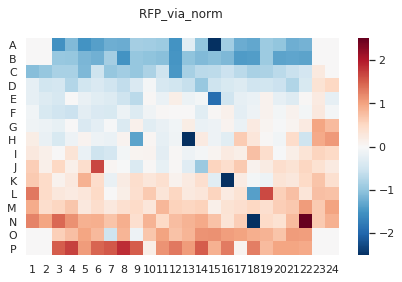

In [41]:
hts_heatmap(df = data, layout_path = layout_path, features = ['RFP_via_norm'], save_as = 'RFP_via_norm_heatmap.png', path = path)

<div align="justify"> Multiplying two features introduces a strong gradient across the plate (row effect). This is a kind of systematic errors and we will normalize it using the median polish algorithm in the next step. Despite the strong gradient, now we can easily identify our 'true' hits in J6, L19, and N22 wells. Let's plot the viability-normalized activity to demonstrate how changes introduced by viability normalization changes 'raw' hits locations. For this purpose, we will add 'Result_raw' column defining hits extracted using RFP signal before viability normalization. </div>


In [42]:
data['Result_raw'] = data['Status']
data['Result_raw'] = np.where((data['RFP_norm'] >= threshold) & (data['Status'] =='Sample'), 'Hit', data['Result_raw'])

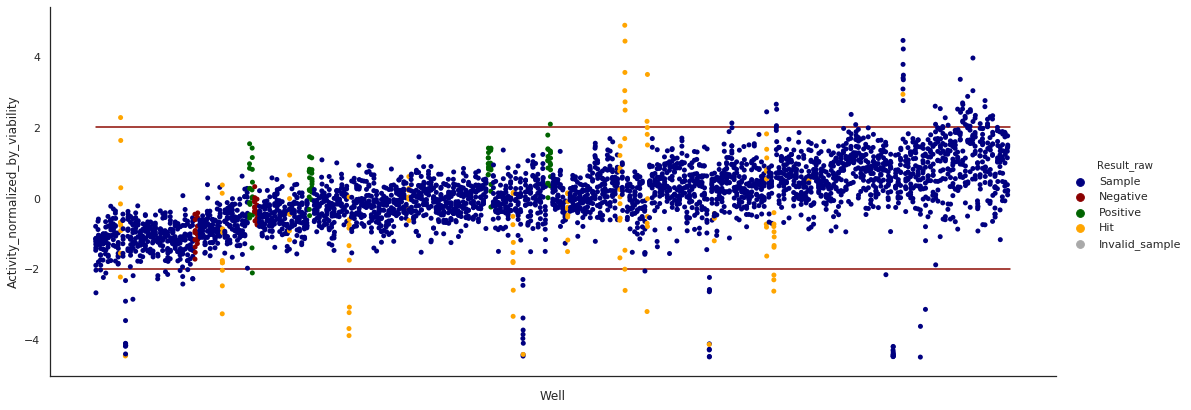

In [43]:
pointplot_plate(df = data,  x = 'Well', y = 'RFP_via_norm',  hue = 'Result_raw', hue_order = hue_order, 
                 threshold = threshold, ylabel = 'Activity_normalized_by_viability', palette = palette,  save_as = 'field_pointplot', path = path)

<div align="justify"> We can see that most of the 'raw' hit fields (yellow points) were moved down below the threshold line after viability normalization. One new hit appeared on the right part of the graph. In addition, this graph demonstrates how a strong row effect can complicate hit selection. Next, we will correct the row effect using 'by well' data. </div> 

### Generate by Well Data
<a id="results"></a>

Averaging measurements by well.

In [44]:
descriptors = data[['Well', 'Status', 'Plate', 'Compound_id', 'lib_name', 'SMILES', 'Compound Name', 'SecName']]
measurements = data[['Well', 'Nuc Area', 'Cell Area', 'Cell_Count', 'Cell_Count_norm', 'Cell_Intensity_norm', 
                     'RFP', 'RFP_via', 'RFP_via_norm']]
results = pd.DataFrame()

for name, group in measurements.groupby('Well'):
    m = group.mean()
    m['Well'] = name
    results  = results .append(m, ignore_index = True )

results = pd.merge(results.copy(), descriptors.drop_duplicates(), how = 'left', on = 'Well')
print(results.shape)
display(results .head())

(368, 16)


,Cell Area,Cell_Count,Cell_Count_norm,Cell_Intensity_norm,Nuc Area,RFP,RFP_via,RFP_via_norm,Well,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName
0,240.0466,1000.4,-0.096317,-0.219583,119.4660,159.8797,154860.9417,-0.881503,A10,Sample,ex_plate1,Compound_0008,example_library,CCOC(=O)NC(C(=O)NC(C)c1ccccc1C)C(C)C,NaN,NaN
1,240.1836,1013.4,-0.043811,-0.249819,117.1018,153.9349,153328.0654,-0.917329,A11,Sample,ex_plate1,Compound_0009,example_library,O=C(COC(=O)c1ccco1)NC1CC1,NaN,NaN
2,253.6417,860.2,-0.662577,0.108024,124.9165,152.6865,128677.8225,-1.493461,A12,Sample,ex_plate1,Compound_0010,example_library,CCc1ccc(OCc2ccccc2C(=O)Nc2ccc3nc(C)cc(N)c3c2)cc1,JTC-801,NaN
3,249.2515,362.5,-2.672757,5.047333,112.4694,506.8975,180404.0444,-0.284503,A13,Sample,ex_plate1,Compound_0011,example_library,CN(CC(=O)Nc1ccccc1C(=O)NCc1ccccc1)Cc1ccc(Cl)s1,NaN,NaN
4,239.3896,1003.5,-0.083797,-0.193422,118.7610,153.2052,150031.2471,-0.994384,A14,Sample,ex_plate1,Compound_0012,example_library,O=C(O)c1cc(Br)cs1,NaN,NaN


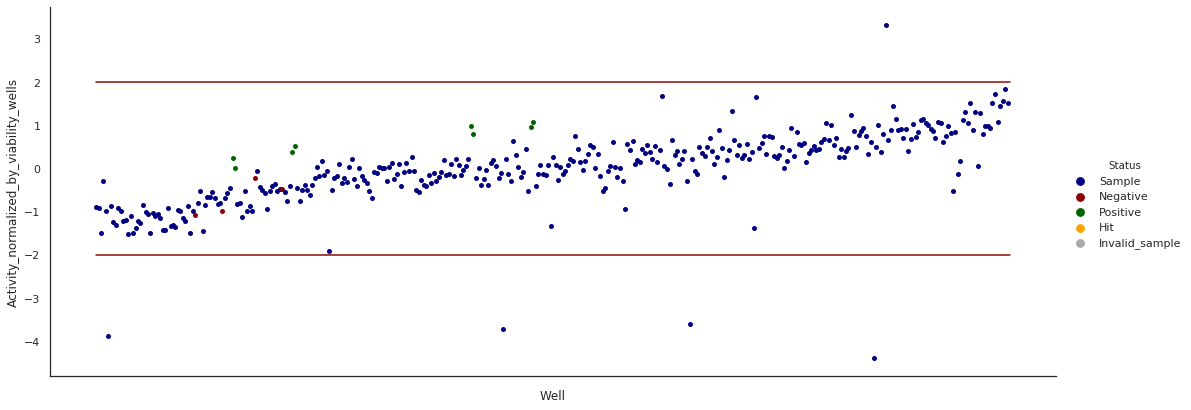

In [45]:
pointplot_plate(df = results,  x = 'Well', y = 'RFP_via_norm',  hue = 'Status', hue_order = hue_order, 
                 threshold = threshold, ylabel = 'Activity_normalized_by_viability_wells', palette = palette,  
                save_as = 'well_pointplot', path = path)

### Systematic Error Correction
<a id="er_cor"></a>

#### Estimate row effect with Welch t-test
<a id="t-test"></a>

<div align="justify"> Since systematic error correction methods themselves can introduce systematic bias when applied to error-free HTS data, we need first to confirm the presence or absence of systematic bias. In our case, we apply Welch’s t-test to compare each row of the assay to the rest of the rows. Hence, each time we have to divide our DataFrame into 'current_row' and 'rest_of_rows'. </div>

In [46]:
from scipy import stats
rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K', 'L', 'M', 'N', 'O', 'P']
t = pd.DataFrame(columns = ['row', 'statistics', 'p-value'])

for r in rows:
    
    # statisticcs for current row
    cur_row_mean = results.copy().set_index('Well').filter(regex = '^((' + r + ').*)*$', axis = 0)[['RFP_via_norm']].mean()[0]
    cur_row_std = results.copy().set_index('Well').filter(regex = '^((' + r + ').*)*$', axis = 0)[['RFP_via_norm']].std()[0]
    cur_row_n = results.copy().set_index('Well').filter(regex = '^((' + r + ').*)*$', axis = 0).shape[0]

    # statistics for rest of the plate
    rest_mean = results.copy().set_index('Well').filter(regex = '^((?!' + r + ').*)*$', axis = 0)[['RFP_via_norm']].mean()[0]
    rest_std = results.copy().set_index('Well').filter(regex = '^((?!' + r + ').*)*$', axis = 0)[['RFP_via_norm']].std()[0]
    rest_n = results.copy().set_index('Well').filter(regex = '^((?!' + r + ').*)*$', axis = 0).shape[0]

    t_score = stats.ttest_ind_from_stats(mean1 = cur_row_mean, std1 = cur_row_std, nobs1 = cur_row_n, \
                                   mean2 = rest_mean, std2 = rest_std, nobs2 = rest_n, equal_var = False)
    t = t.append({'row':r, 'statistics': round(t_score[0],2), 'p-value':round(t_score[1],4)}, ignore_index = True)

display(t)

,row,statistics,p-value
0,A,-8.41,0.0000
1,B,-19.75,0.0000
2,C,-9.31,0.0000
3,D,-5.60,0.0000
4,E,-3.02,0.0045
5,F,-2.43,0.0172
6,G,0.05,0.9613
7,H,-0.82,0.4224
8,I,1.37,0.1764
9,J,2.33,0.0258


<div align="justify"> The p-value less than 0.05 means that there is less than a 5% chance of finding the observed values from row 'A' given the data from the rest of the plate. Hence we should reject the null hypothesis that row 'A' does not contain a systematic error. In our plate, rows A-F and L-P contain significant systematic errors, so we can apply a correction. </div>

<div class="alert alert-block alert-info"><b>Tip:</b> Scipy calculates p-value based on the two tailed case. If we just want the p-value of the one-tail, we can divide this value by 2. </div>

### Median Polish Normalization
<a id="import"></a>

Our data contains 368 rows(wells) so that we need to add 16 missing wells to get the standard 384 well plate pattern. 
 - Add missing wells to the results DataFrame to get 384 rows.
 - Fill NaN values in the missing rows with plate sample mean.
 - Extract RFP_via values and reshape to get 2D matrix in the form of the plate (16x24).
 - Calculate gradient pattern using median polish algorithm.
 - Subtract gradient pattern from the original matrix.

In [47]:
# add missing wells from the layout file
all_wells = pd.DataFrame({'Well':np.asarray(pd.ExcelFile(layout_path).parse('Well')).reshape(-1)})
results = pd.merge(all_wells, results, how = 'left', on ='Well')

# calculate red_via_norm samples mean
samples = results[results['Status'] == 'Sample'].dropna() 
mean = samples['RFP_via'].mean()
print(mean)

# fill missing red_via_norm values with the mean of samples
results['RFP_via'] = results['RFP_via'].fillna(mean)

print(results.shape)
display(results.head())

163002.2193857143
(384, 16)


,Well,Cell Area,Cell_Count,Cell_Count_norm,Cell_Intensity_norm,Nuc Area,RFP,RFP_via,RFP_via_norm,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName
0,A1,NaN,NaN,NaN,NaN,NaN,NaN,163002.219386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A2,NaN,NaN,NaN,NaN,NaN,NaN,163002.219386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A3,241.9437,958.3,-0.266357,-0.467907,118.5758,136.0127,127725.254200,-1.515725,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN
3,A4,241.9965,993.9,-0.122570,-0.381945,117.3357,147.4671,145064.780600,-1.110461,Sample,ex_plate1,Compound_0002,example_library,CCOC(=O)c1c(S(=O)(=O)N2CCOCC2)c(-c2ccccc2)n(-c...,NaN,NaN
4,A5,245.2987,1014.5,-0.039368,-0.778158,114.4257,129.7085,128303.111300,-1.502219,Sample,ex_plate1,Compound_0003,example_library,Cn1nc(-c2ccc(C=C(C#N)S(=O)(=O)c3ccc(C(F)(F)F)c...,NaN,NaN


#### Extract rev_via_norm values and reshape to get 2D matrix in the form of the plate (16x24).

In [48]:
rfp_arr = results['RFP_via'].values.reshape(16, 24)
print(rfp_arr.shape)

(16, 24)


#### Calculate and plot gradient pattern

In [49]:
# medain polish function
def median_polish_pattern(arr, max_iterations = 100):
    '''Implements Tukey's median polish alghoritm for additive models'''
    res = arr.copy()
    for i in range(max_iterations):
        row_medians = np.median(res,1) 
        res  -= row_medians[:,np.newaxis] 
        col_medians = np.median(res,0) 
        res -= col_medians
    return arr-res

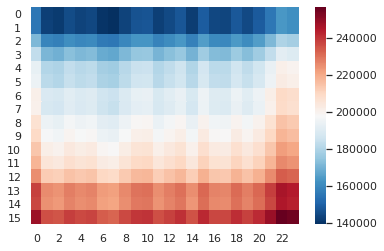

In [50]:
pattern =  median_polish_pattern(rfp_arr) 
#plot the gradient pattern
sns.heatmap(pattern, cmap = 'RdBu_r')

#### Subtract gradient pattern

In [51]:
results['mp_pattern'] = pattern.reshape(-1)
results['RFP_via_mp'] = results['RFP_via'] - results['mp_pattern']
results = normalize_z(results.copy(), 'RFP_via_mp')

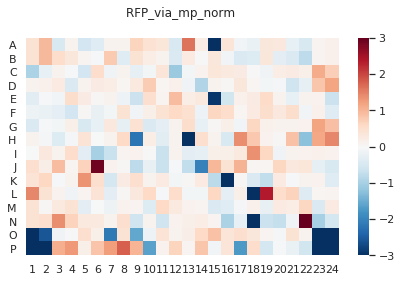

In [52]:
hts_heatmap(df = results, layout_path = layout_path, features = ['RFP_via_mp_norm'], save_as = 'heatmap_mp.png', path = path)

#### Select hits and plot

In [53]:
display(results.head())

,Well,Cell Area,Cell_Count,Cell_Count_norm,Cell_Intensity_norm,Nuc Area,RFP,RFP_via,RFP_via_norm,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName,mp_pattern,RFP_via_mp,RFP_via_mp_norm
0,A1,NaN,NaN,NaN,NaN,NaN,NaN,163002.219386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155157.707930,7844.511456,0.443314
1,A2,NaN,NaN,NaN,NaN,NaN,NaN,163002.219386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142700.110938,20302.108448,0.981086
2,A3,241.9437,958.3,-0.266357,-0.467907,118.5758,136.0127,127725.254200,-1.515725,Sample,ex_plate1,Compound_0001,example_library,Cc1nn(C)c2nc(C(C)C)cc(C(=O)N3CCN(C(=O)C4CC4)CC...,NaN,NaN,141548.888616,-13823.634416,-0.492059
3,A4,241.9965,993.9,-0.122570,-0.381945,117.3357,147.4671,145064.780600,-1.110461,Sample,ex_plate1,Compound_0002,example_library,CCOC(=O)c1c(S(=O)(=O)N2CCOCC2)c(-c2ccccc2)n(-c...,NaN,NaN,145154.990700,-90.210100,0.100787
4,A5,245.2987,1014.5,-0.039368,-0.778158,114.4257,129.7085,128303.111300,-1.502219,Sample,ex_plate1,Compound_0003,example_library,Cn1nc(-c2ccc(C=C(C#N)S(=O)(=O)c3ccc(C(F)(F)F)c...,NaN,NaN,143346.644335,-15043.533035,-0.544720


In [54]:
results['Result'] = results['Status']
results['Result'] = np.where((results['RFP_via_mp_norm'] > threshold) & (results['Status'] =='Sample'), 'Hit', results['Result'])

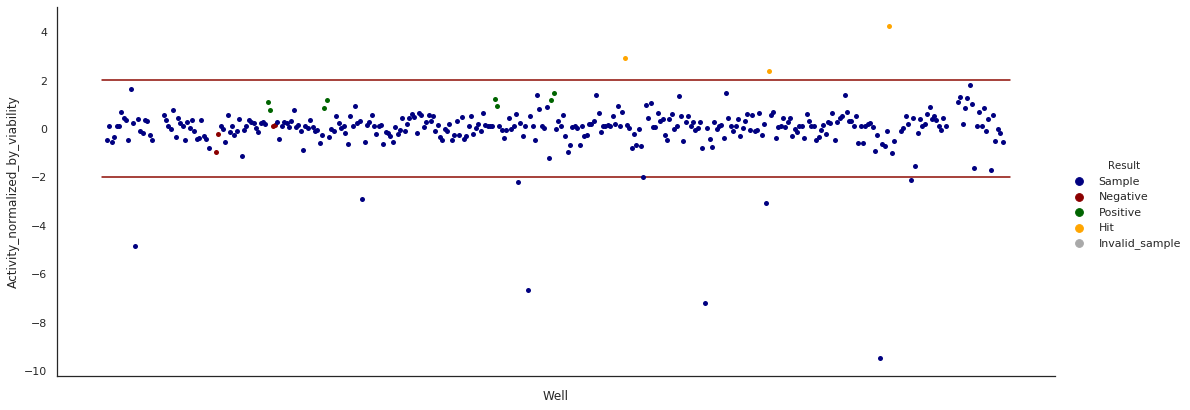

In [55]:
pointplot_plate(df = results,  x = 'Well', y = 'RFP_via_mp_norm',  hue = 'Result', hue_order = hue_order, 
                 threshold = threshold, ylabel = 'Activity_normalized_by_viability', palette = palette,  
                save_as = 'well_pointplot_mp', path = path)

### Running QC
<a id="qc"></a>

,Feature,Status,size,mean,std,var,Z_factor,SB
0,RFP_via_mp_norm,Negative,4.0,-2.348209e-01,0.512014,0.262158,-0.7057,-4.581184
1,RFP_via_mp_norm,Positive,8.0,1.075758e+00,0.233137,0.054353,-0.7057,-4.581184
2,RFP_via_mp_norm,Sample,356.0,-1.715232e-17,1.000000,1.000000,-0.7057,-4.581184


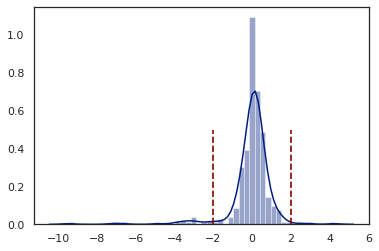

In [56]:
#calculate statistics
stats = sum_statistics(df = results, feature = 'RFP_via_mp_norm')
stats.to_csv(path + '//sum_statistics.csv', index = False)
display(stats)
    
# histogram
histogram_feature(df = results, feature = 'RFP_via_mp_norm', save_as = 'histogram_mp.png', path = path)

#### Create hits table

In [57]:
hits = results[results['Result'] == 'Hit']
display(hits)

,Well,Cell Area,Cell_Count,Cell_Count_norm,Cell_Intensity_norm,Nuc Area,RFP,RFP_via,RFP_via_norm,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName,mp_pattern,RFP_via_mp,RFP_via_mp_norm,Result
221,J6,176.5431,281.0,-3.001931,5.061900,88.8174,896.6488,264085.5697,1.671324,Sample,ex_plate1,Compound_0183,example_library,COc1ccccc1-n1cnnc1SCC(=O)NC(C)c1ccc(Cl)cc1Cl,NaN,NaN,198680.710690,65404.859010,2.928087,Hit
282,L19,202.4229,958.1,-0.267165,0.276892,109.4225,278.2538,263620.8038,1.660461,Sample,ex_plate1,Compound_0236,example_library,Cn1ncc(C(N)=O)c1[N+](=O)[O-],NaN,NaN,210821.174490,52799.629310,2.383943,Hit
333,N22,198.4323,1046.0,0.087858,0.029306,106.0138,326.7301,334343.7831,3.313417,Sample,ex_plate1,Compound_0279,example_library,NC(=O)C1=CN(C(=O)Nc2ccc(Cl)cc2Cl)CCC1C(F)(F)F,NaN,NaN,238458.378067,95885.405033,4.243875,Hit


<div align="justify"> Depending on goals and experimental systems, you may want to select more hits by lowering the threshold and analyze them by another assay (confirmation assay).</div>

#### Save results to csv
<a id="save"></a>

In [58]:
results.to_csv(path + '//image_screen_results.csv', index = False)
hits.to_csv(path + '//image_screen_hits.csv', index = False)

#### Create ppt report and clean output folder

In [59]:
report = create_presentation(path).save(path +'//image_screen_report.pptx')

In [60]:
# Clean output directory
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)
os.remove(path + '//sum_statistics.csv')

### Conclusions
<a id="conclusions"></a>

The success of HTS strategies depends on the effectiveness of both normalization methods and study design. In our assay, initial background normalization of intensities was performed at the level of image analysis software.
Then, in this tutorial we performed multiple normalization steps:  
  - viability-normalization
  - systematic-error correction using median polish algorithm 
  - z-score normalization

In pnenotypic screening, multiplexing imaging approach allows us to measure functional readouts (in our case RFP fluorescence) in line with other functional or structural changes in the cell, as well as with cell viability\cell count. Here we used combination of RFP fluorescence and cell viability, which allowed us to reject toxic compounds at this early stage and focus on more promising hits.  We will continie this experiment in 'imaging based dose response' notebook. 

